# Chessboard detection

In [7]:
import imageio, tqdm
import numpy as np
import joblib
import matplotlib.pyplot as plt
import cv2, os, time, glob
import networkx as nx
na = np.newaxis

def orient_board(uvs, markers, board=(7,10)):
    """flip order of chessboard points so that first is farthest from markers"""
    
    distance = np.sqrt(((uvs - markers.mean(1)[:,na,:])**2).sum(-1))
    flip = distance[:,0] < distance[:,-1]
    
    cols,rows = board
    uvs[flip] = uvs[flip].reshape(-1,rows,cols,2)[:,::-1].reshape(-1,rows*cols,2)   
    return uvs

board = (7,10)

prefixes = []
img_sizes = []
all_chessboard_uvs = []

# load and orient chessboard detections
calib_dir = '../../../../data/23_3_16_calibration/'
for path in tqdm.tqdm(glob.glob(calib_dir+'/*.corners.p')):
    
    prefix = path.split('.corners')[0]
    uvs,ixs = map(np.array,joblib.load(path))
    markers = joblib.load(prefix+'.circle_plus.p')['uv']
    uvs = orient_board(uvs, markers[ixs], board=board)
    chessboard_uvs = np.zeros((18001,70,2))*np.nan
    chessboard_uvs[ixs] = uvs

    all_chessboard_uvs.append(chessboard_uvs)
    prefixes.append(prefix)

all_calib_uvs = np.array(all_chessboard_uvs)

img_sizes = [
    (1280, 1024),
    (1280, 1024),
    (1280, 832),
    (1280, 832),
    (1280, 832),
    (1280, 832)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


# Initial calibration

In [12]:
from multicam_calibration import calibrate, plot_residuals, chessboard, bundle_adjust

In [9]:
chess_board_shape = (7,10)
chess_board_square_size = 12.5
calib_objpoints = chessboard.generate_objpoints(chess_board_shape, chess_board_square_size)

all_extrinsics, all_intrinsics, calib_poses = calibrate(
    all_calib_uvs, img_sizes, calib_objpoints, root=0)


Estimating camera intrinsics


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:21<00:00,  3.57s/it]


Initializing calibration object poses


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]

Estimating camera extrinsics
Merging calibration object poses


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/it]


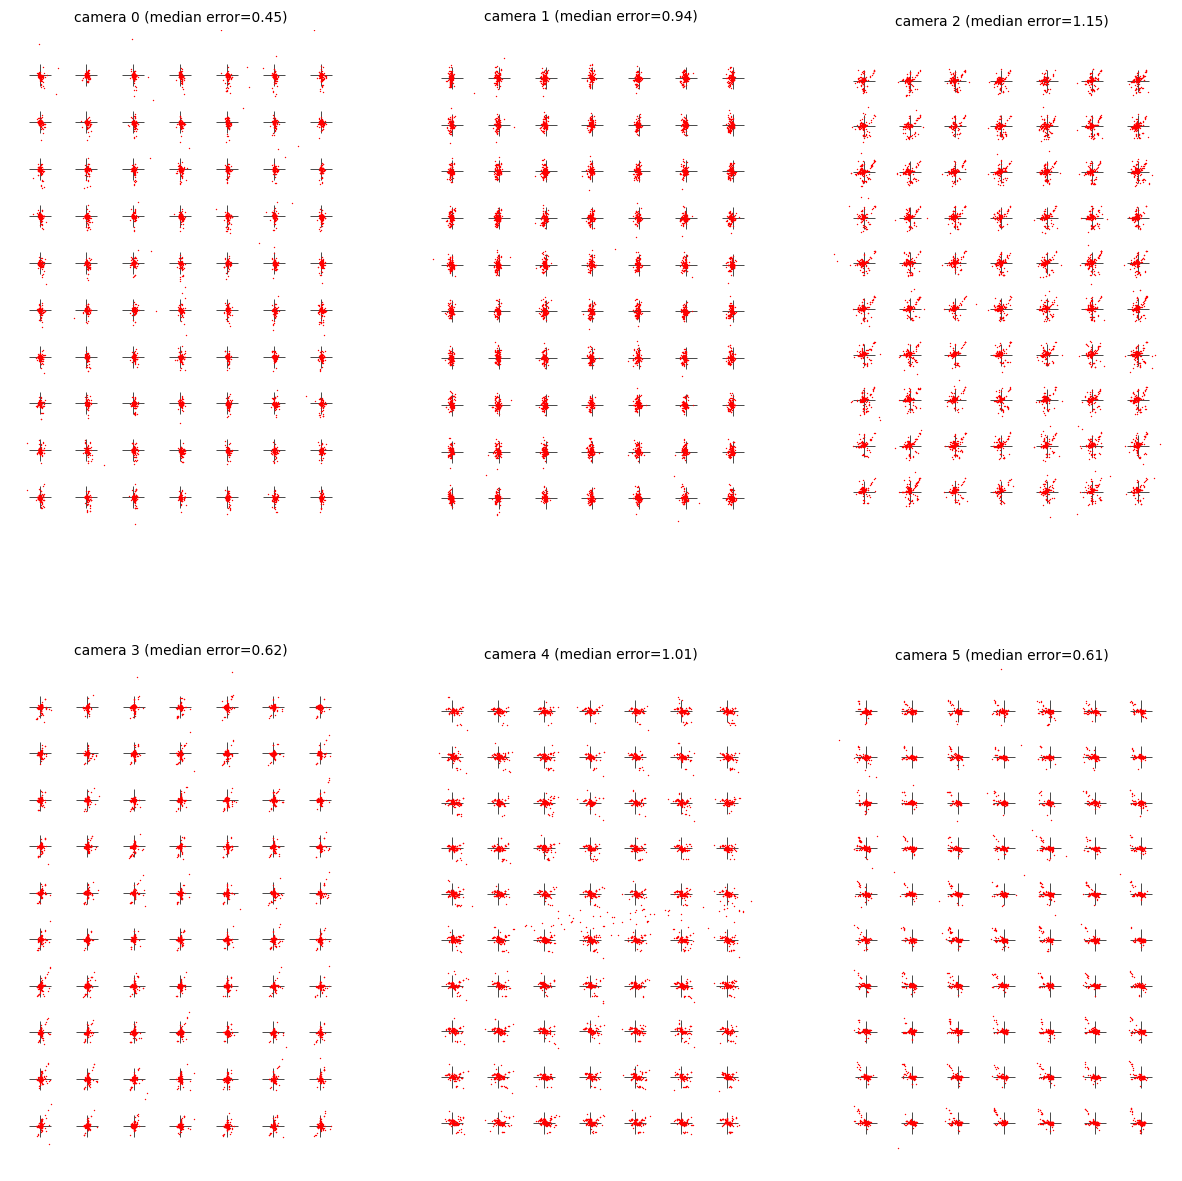

In [17]:
fig, mean_squared_error, reprojections, transformed_reprojections = plot_residuals(
    all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses)

# Bundle Adjustment

In [13]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=5000, ftol=1e-4)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2139e+06                                    6.72e+07    
       1              4         1.1292e+06      8.47e+04       7.01e+01       5.72e+07    
       2              5         8.0329e+05      3.26e+05       2.29e+01       3.36e+07    
       3              6         7.8565e+05      1.76e+04       6.26e+01       5.87e+06    
       4              7         7.1165e+05      7.40e+04       1.87e+01       3.34e+06    
       5              8         6.6478e+05      4.69e+04       4.15e+01       3.89e+06    
       6             10         6.3998e+05      2.48e+04       1.04e+01       2.84e+06    
       7             11         6.3606e+05      3.92e+03       1.46e+01       2.56e+06    
       8             12         6.3013e+05      5.93e+03       4.72e+00       2.76e+06    
       9             13         6.2732e+05      2.81e+03       1.02e+01       2.92e+06    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.06it/s]


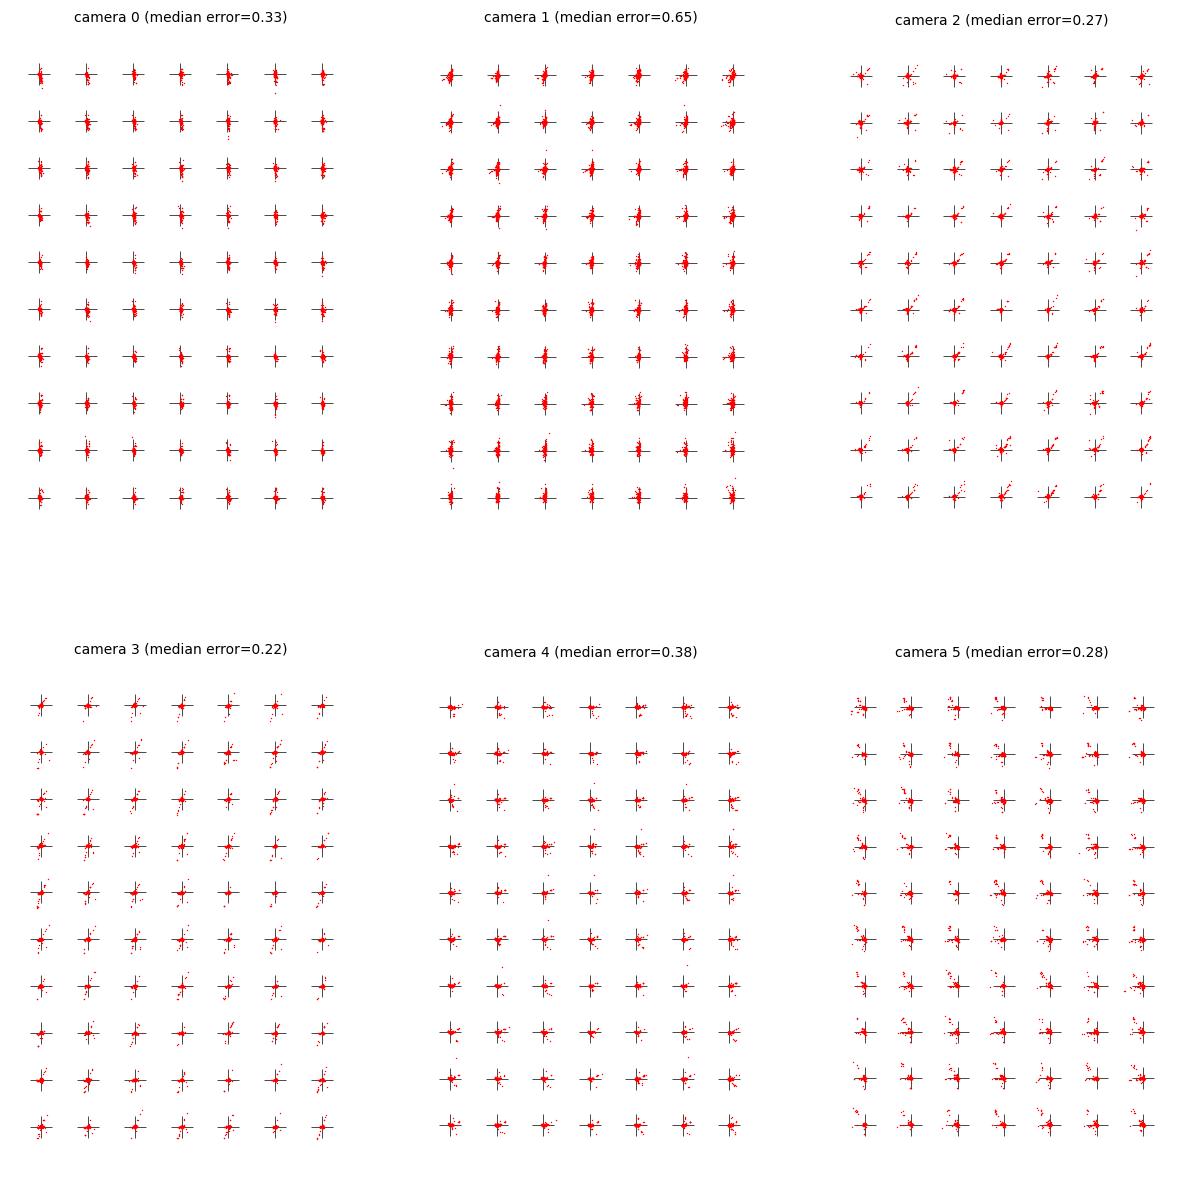

In [29]:
fig, median_error, reprojections, transformed_reprojections = plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses)

In [ ]:
save_path = 'path/to/output'
camera_names = ['top', 'bottom', 'side2', 'side4', 'side1', 'side3']
save_calibration(adj_extrinsics, adj_intrinsics, save_path, camera_names)